# Downsampling Uncertainty

## Idea

Suppose we have access to event-level trade data (or any financial time series) and suppose we are interested in some coarse graining. This might be bucketing into time bars or some form of statistical downsampling. For definiteness, lets set the coarse graining to be given by a CUSUM filter that samples from high frequency noisy data only if the moves in the data exceed some threshold. The resulting series is still in information time but is denoised by rejection (rather than smoothing). Now, we assume that we are able to pick the filter threshold well enough to capture a microstructural noise-floor. Then, we can fit the downsampled data using a Gaussian process and generate a distribution that generates the possible paths that connect the sampled points. The benefits of this are (a) we need not restrict to any particular realization of noise and can actually draw samples from a fitted noise distribution (b) we can quantify sampling uncertainty (c) we can make rudimentary forecasts with uncertainty.

I will focus on the latter two as there are better tools one can employ for forecasting. We will hopefully see trade-off between sample sparsity and average goodness-of-fit, providing a validation of the downsampling scheme.

## Implementation

In [1]:
from filtering.cusum import cusum
import matplotlib.pyplot as plt
from alpaca_trade_api.rest import REST
from data.historical import Trade
api = REST()

In [7]:
import pandas as pd
import numpy as np
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
tf.enable_v2_behavior()

### CUSUM downsampling

In [3]:
Data = Trade(api, 'MSFT', start="2022-04-14", end="2022-04-14", limit=100000)
print(Data.shape)
Data.head()

(84324, 4)


,price,size,seconds_elapsed,hour
timestamp,,,,
2022-04-14 08:00:00.000747+00:00,288.20,1,1.0,8
2022-04-14 08:00:00.030654208+00:00,288.98,65,1.0,8
2022-04-14 08:00:00.229343+00:00,288.50,25,1.0,8
2022-04-14 08:00:02.618797368+00:00,288.34,40,3.0,8
2022-04-14 08:00:06.448608562+00:00,288.32,1,7.0,8


In [565]:
prices = Data['price']
idx = cusum(prices, 0.34)
filtered_prices = prices.loc[idx]
filtered_prices.name = 'filtered_price'
filtered_prices = pd.concat([filtered_prices, prices], axis=1)
print("number of samples: ",len(filtered_prices)-filtered_prices.isna().sum().sum())

number of samples:  507


<AxesSubplot:>

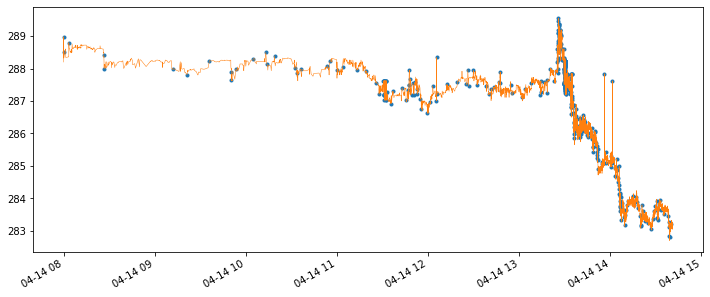

In [566]:
filtered_prices.iloc[:, 0].plot(style='.', figsize=(12, 5))
filtered_prices.iloc[:, 1].plot(linewidth=0.5, figsize=(12, 5))

### Probabilistic model

Based on [this](https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Gaussian_Process_Regression_In_TFP.ipynb#scrollTo=1DOkwqQEsXVs)

In [633]:
# Excuse the ugly repeated code

cut_off = 200
real_time_cutoff = filtered_prices.loc[idx].index[cut_off]
print(real_time_cutoff)
t = np.linspace(0, 1, len(filtered_prices))
observation_index_points_ = t[~filtered_prices.filtered_price.isna()]
observation_index_points_ = observation_index_points_.reshape((len(observation_index_points_),1))[:cut_off]
observation_index_points_ = observation_index_points_*(1/observation_index_points_[-1])
observations_ = filtered_prices.filtered_price.dropna().values[:cut_off]
mean = np.mean(observations_)
observations_ = observations_-mean

2022-04-14 13:30:01.906000+00:00


In [634]:
tfb = tfp.bijectors
tfd = tfp.distributions
tfk = tfp.math.psd_kernels
def build_gp(amplitude, length_scale, observation_noise_variance):
  kernel = tfk.ExponentiatedQuadratic(amplitude, length_scale)

  return tfd.GaussianProcess(
      kernel=kernel,
      index_points=observation_index_points_,
      observation_noise_variance=observation_noise_variance)

gp_joint_model = tfd.JointDistributionNamed({
    'amplitude': tfd.LogNormal(loc=0., scale=np.float64(1)),
    # 'length_scale': tfd.LogNormal(loc=0., scale=np.float64(0.357)),
    'length_scale': tfd.Exponential(rate=np.float64(0.3)),
    # 'length_scale': tfd.Gamma(concentration=0.2, rate=np.float64(0.357)),
    'observation_noise_variance': tfd.LogNormal(loc=0., scale=np.float64(1.5)),
    'observations': build_gp,
})
# gp_joint_model

In [635]:
constrain_positive = tfb.Shift(np.finfo(np.float64).tiny)(tfb.Exp())

amplitude_var = tfp.util.TransformedVariable(
    initial_value=1.,
    bijector=constrain_positive,
    name='amplitude',
    dtype=np.float64)

length_scale_var = tfp.util.TransformedVariable(
    initial_value=1,
    bijector=constrain_positive,
    name='length_scale',
    dtype=np.float64)

observation_noise_variance_var = tfp.util.TransformedVariable(
    initial_value=1.6,
    bijector=constrain_positive,
    name='observation_noise_variance_var',
    dtype=np.float64)

trainable_variables = [v.trainable_variables[0] for v in
                       [amplitude_var,
                       length_scale_var,
                       observation_noise_variance_var]]
print(trainable_variables)
def target_log_prob(amplitude, length_scale, observation_noise_variance):
  return gp_joint_model.log_prob({
      'amplitude': amplitude,
      'length_scale': length_scale,
      'observation_noise_variance': observation_noise_variance,
      'observations': observations_
  })

[<tf.Variable 'amplitude:0' shape=() dtype=float64, numpy=0.0>, <tf.Variable 'length_scale:0' shape=() dtype=float64, numpy=0.0>, <tf.Variable 'observation_noise_variance_var:0' shape=() dtype=float64, numpy=0.47000362924573563>]


In [636]:
# Now we optimize the model parameters.
num_iters = 1000
optimizer = tf.optimizers.Adam(learning_rate=.01)

# Use `tf.function` to trace the loss for more efficient evaluation.
@tf.function(autograph=False, jit_compile=False)
def train_model():
  with tf.GradientTape() as tape:
    loss = -target_log_prob(amplitude_var, length_scale_var,
                            observation_noise_variance_var)
  grads = tape.gradient(loss, trainable_variables)
  optimizer.apply_gradients(zip(grads, trainable_variables))
  return loss

# Store the likelihood values during training, so we can plot the progress
lls_ = np.zeros(num_iters, np.float64)
for i in range(num_iters):
  loss = train_model()
  lls_[i] = loss

print('Trained parameters:')
print('amplitude: {}'.format(amplitude_var._value().numpy()))
print('length_scale: {}'.format(length_scale_var._value().numpy()))
print('observation_noise_variance: {}'.format(observation_noise_variance_var._value().numpy()))

Trained parameters:
amplitude: 0.4904079299454698
length_scale: 0.03868893875061183
observation_noise_variance: 0.06798930788395936


Text(0, 0.5, 'Log marginal likelihood')

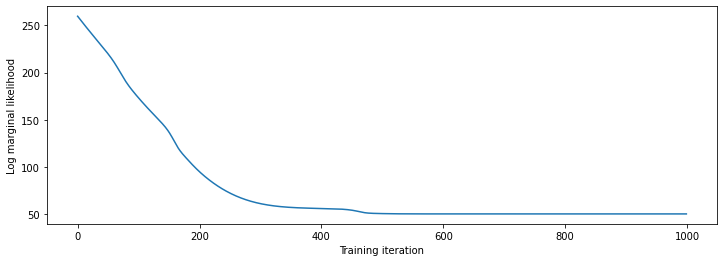

In [637]:
# Plot the loss evolution
plt.figure(figsize=(12, 4))
plt.plot(lls_)
plt.xlabel("Training iteration")
plt.ylabel("Log marginal likelihood")

In [641]:
predictive_index_points_ = np.linspace(0, 1.1, 400, dtype=np.float64)
# Reshape to [200, 1] -- 1 is the dimensionality of the feature space.
predictive_index_points_ = predictive_index_points_[..., np.newaxis]
optimized_kernel = tfk.ExponentiatedQuadratic(amplitude_var, length_scale_var)
gprm = tfd.GaussianProcessRegressionModel(
    kernel=optimized_kernel,
    index_points=predictive_index_points_,
    observation_index_points=observation_index_points_,
    observations=observations_,
    observation_noise_variance=observation_noise_variance_var,
    predictive_noise_variance=0.)
num_samples = 150
samples = gprm.sample(num_samples)

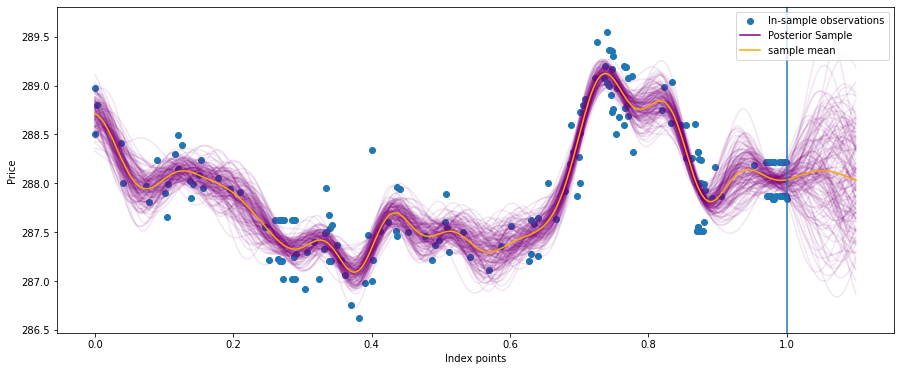

In [643]:
plt.figure(figsize=(15, 6))

plt.scatter(observation_index_points_[:, 0], observations_+mean,
            label='In-sample observations')
# plt.scatter(observation_index_points_test[:, 0], observations_test,
#             label='Out-of-sample observations', c='red')
for i in range(num_samples):
  plt.plot(predictive_index_points_, samples[i, :]+mean, c='purple', alpha=.1,
           label='Posterior Sample' if i == 0 else None)
plt.plot(predictive_index_points_, samples[:, :].numpy().mean(axis=0)+mean, label="sample mean", c='orange')
plt.axvline(1)
leg = plt.legend(loc='upper right')
for lh in leg.legendHandles:
    lh.set_alpha(1)
plt.xlabel(r"Index points")
plt.ylabel("Price")
plt.show()